In [1]:
from plotting_utils import *
import matplotlib.pyplot as plt
from cycler import cycler
plt.style.use('ggplot')

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 8
#plt.rcParams['figure.titlesize'] = 15
#plt.rcParams['figure.titleweight'] = 'bold'

#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler(color=['r', 'g', 'b', 'y']) +
#                           cycler(linestyle=['-', '--', ':', '-.'])))
plt.rc('axes', prop_cycle=(cycler(color=['red', 'green', 'blue', 'yellow','cyan', 'magenta',\
                                         'black', 'orange', 'maroon', 'lime', 'aqua', \
                                         'indigo', 'darkviolet', 'dimgray', 'deeppink'])))

In [2]:
def plot2(ax, data, field, plot_term, params, smooth = None):
    '''data is already in filtered form
    data: {name:list of data_points} '''
    def last(a):
        return a[-1]

    colours = ['red', 'green', 'blue', 'yellow','cyan', 'magenta',\
                'black', 'orange', 'maroon', 'lime', 'aqua', \
                'indigo', 'darkviolet', 'dimgray', 'deeppink']

    all_plots = []
   # all_points = {}
    lookup = set()
    exclude_last_points = 1
    this_cmap = {}
    c_cpy = colours[:]
    c_taken = params["cmap"].values()
    for c in c_taken:
        if c in c_cpy:
            c_cpy.remove(c)
    for i,(k, v) in enumerate(data.items()):
        if plot_term in k:
            exp_id = k.split("_")
            ind = exp_id.index(plot_term)
            plot_term_value = exp_id[ind+1]
            if not plot_term_value in lookup:
                lookup.add(plot_term_value)
                label = params["aliasplotterm"] + ' = ' + plot_term_value
                if not smooth is None:
                    new_data = moving_average_filter(v[field], smooth)
                    exclude_last_points = smooth + 1
                else:
                    new_data = v[field][:]
                x = np.arange(len(new_data))
                
                if label in params["cmap"]:
                    c_hldr = params["cmap"][label]
                else:
                    c_hldr = c_cpy[0]
                    del c_cpy[0]
                this_cmap[label] = c_hldr
                #all_points[label] = (x, new_data, float(plot_term_value))
                handle = ax.plot(x[7:-exclude_last_points], new_data[7:-exclude_last_points], label = label, color = c_hldr)[0]
                all_plots.append((handle,label, float(plot_term_value)))


  #  all_points = {k: v for k, v in sorted(all_points.items(), key=lambda item: item[1][2], reverse = True)}

    handles, labels = ax.get_legend_handles_labels()
    label_id = [float(l.split(" = ")[-1]) for l in labels]
    all_plots = [tuple(i) for i in zip(handles, labels, label_id)]
   # all_plots.sort(key = last, reverse=True)


   # print(handles, labels)

    ax.set_xlabel(params["xlabel"], fontsize = params["xlabelsize"])  # Add an x-label to the axes.
    ax.set_ylabel(params["ylabel"], fontsize = params["ylabelsize"])  # Add a y-label to the axes.
    ax.set_title(params["title"], fontsize = params["titlesize"])  # Add a title to the axes.

  #  handles = [p[0] for p in all_plots]
   # lbls = [p[1] for p in all_plots]
    h,l,_ = zip(*all_plots)
    return h, l, this_cmap
    #ax.legend(h, l)  # Add a legend.

    
#############################################################################################################

def plot4(ax, data,field, plts, params, smooth = None):
    ''' Plots the key-label pairs in plt where the key is a data item (single plot)'''
    colours = ['red', 'green', 'blue', 'yellow','cyan', 'magenta',\
                'black', 'orange', 'maroon', 'lime', 'aqua', \
                'indigo', 'darkviolet', 'dimgray', 'deeppink']
   # all_plots = []
    
    this_cmap = {}
    c_cpy = colours[:]
    c_taken = params["cmap"].values()
    for c in c_taken:
        if c in c_cpy:
            c_cpy.remove(c)
    
    for plt_key, plt_label in plts.items():
        assert plt_key in data
        #Data:
        d = data[plt_key]
        if not smooth is None:
            smooth_data = moving_average_filter(d[field], smooth)
            exclude_last_points = smooth + 1
        else:
            smooth_data = d[field]
            exclude_last_points = 1
        x = np.arange(len(smooth_data))
        #Colours:
        if plt_label in params["cmap"]:
            c_hldr = params["cmap"][plt_label]
        else:
            c_hldr = c_cpy[0]
            del c_cpy[0]
        this_cmap[plt_label] = c_hldr
        #Plot:
        handle = ax.plot(x[7:-exclude_last_points], smooth_data[7:-exclude_last_points], label = plt_label, color = c_hldr)[0]
      #  all_plots.append((handle,label, float(plot_term_value)))
        
        
    handles, labels = ax.get_legend_handles_labels()
    
    ax.set_xlabel(params["xlabel"], fontsize = params["xlabelsize"])  # Add an x-label to the axes.
    ax.set_ylabel(params["ylabel"], fontsize = params["ylabelsize"])  # Add a y-label to the axes.
    ax.set_title(params["title"], fontsize = params["titlesize"])  # Add a title to the axes.
    
    return handles, labels, this_cmap

In [3]:
from tabulate import tabulate
def get_mean_std(data, last_data, field, keys_alias_dict = None, print_ = True, no_table = False):
    '''Returns a table of mean std of data.
    keys_alias_dict can specify the keys in data to be
    plotted. The value item can specify an alias term, or
    be none to use the key as data label.'''
    csv_records = []
    #sep = ","
    #end_char = "\n"
    assert last_data > -1
    table = []
    hdrs = ["Item", "Mean", "Std"]
    no_table_dict = {}
    if keys_alias_dict is None:
        for k,v in data.items():
            new_d = np.array(v[field][-last_data:])
            m = new_d.mean()
            std = new_d.std()
            hldr = [k,m,std]
            if no_table:
                no_table_dict[ak] = (m,std)
            table.append(hldr)
            csv_records.append(hldr)
    else:
        for k, ak in keys_alias_dict.items():
            new_d = np.array(data[k][field][-last_data:])
            m = new_d.mean()
            std = new_d.std()
            if ak is None:
                ak = k
            hldr = [ak,m,std]
            if no_table:
                no_table_dict[ak] = (m,std)
            table.append(hldr)
            csv_records.append(hldr)

    if print_:
        print(tabulate(table, headers = hdrs))
        
    if no_table:
        return no_table_dict
    else:
        return csv_records

In [4]:
def make_csv(table_dict, name):
    ''' table_dict contains {header: [row_label, mean, std]}'''
    sep = ","
    line_end = "\n"
    rows = {}
    header = "Architecture"
    for k,v in table_dict.items():
        header += sep + k
        for r in v:
            m = str(np.round(r[1], 2))
            std = str(np.round(r[2],1))
            if not r[0] in rows:
                rows[r[0]] = r[0]
            rows[r[0]] += sep + m + "$\pm$" + std
    csv_txt = header + line_end
    for v in rows.values():
        csv_txt += v + line_end
    f = open(make_exist(name), 'w')
    f.write(csv_txt)
    f.close()
    #print(csv_txt)
        

In [86]:
y = [2,3,5]

print(y2)

[2, 3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5]


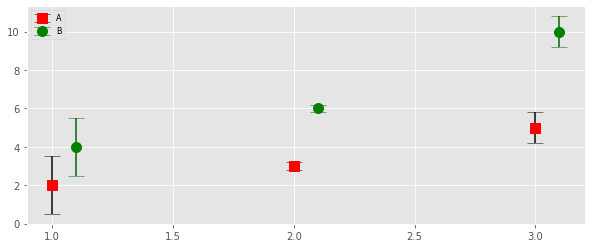

In [11]:
x = [1,2,3]
y = [2,3,5]
y_err = [1.5, 0.2, 0.8]
fig, (ax1) = plt.subplots(1,1, figsize=(10,4))
ax1.errorbar(x,y, yerr = y_err, fmt = 's', ms = 10, capsize = 8.0, capthick = 0.5, ecolor = 'k', label= 'A')
y2 = [i*2 for i in y]
x2 = [i+0.1 for i in x]
ax1.errorbar(x2,y2, yerr = y_err, color='g', fmt = 'o', ms = 10, capsize = 8.0, capthick = 0.5, ecolor = 'darkgreen', label = "B")
ax1.legend()
plt.show()

In [46]:
# def scatter_errorbars(ax_tuple, data, plt_xvalue_dict, fields_title_dict, last_data = -100):
#     assert len(ax_tuple) == len(fields_title_dict)
#     all_ax = []
#     for ax, field, title in zip(ax_tuple, fields_title_dict.keys(), fields_title_dict.values()):
#         all_ax.append(ax)
#         x_vals = []
#         y_vals = []
#         y_err = []
#         for plt_name, x_val in plt_xvalue_dict.items():
#             keys_alias_dict = {}
#             keys_alias_dict[plt_name] = str(x_val)
#             result = get_mean_std(data, last_data, field, key_alias_dict, no_table = True)
#             (m, std) = result[plt_name]
#             x_vals.append(x_val)
#             y_vals.append(m)
#             y_err.append(std)
#         ax.errorbar(x_vals,y_vals, yerr = y_err,fmt = 's', ms = 5,\
#                     capsize = 8.0, capthick = 0.5, ecolor = 'k')
#         ax.set_title(title, fontsize = 15) 
#     return all_ax
            
    

# Reward Types

# Fully Cooperative

## 1. With increasing reward depending on how many agents are on the goal:
(search navigation-v6_1)

rewad structure:

## stepr = nagennts * -0.2

object_collision = -0.05 #-0.015#-0.1  #Changed to 0.0
        agent_collision = -0.4
        goal_reached= 0.05
        finish_episode = 0.0
        
        
## for reaching goals agents receive reward: (n_agents_on_goal**2.5) * rewards.goal_reached


For this experiment the learning curves and rendering show that MAAC converges to a suboptimal equilibrium whilst PPO does not. MAAC agents only allows three agents to finish whilst the last agent waits, even though it is resulting in less reward.

In [7]:
source = '/home/james/Desktop/Gridworld/EXPERIMENTS/2A2'
all_data = get_event_data(source)

In [8]:
print(all_data.keys())

dict_keys(['benchmark_2999', 'benchmark_9999', 'benchmark_5999', 'benchmark_8999', 'benchmark_99999', 'benchmark_15000', 'benchmark_29999', 'benchmark_1499', 'benchmark_149999', 'benchmark_75000', 'benchmark_60000', 'benchmark_30000', 'benchmark_90000', 'benchmark_45000'])


In [5]:
#navigation-v6_1
#Benchmark plots

ppo_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_ppo_globalr_arc_primal6_env_independent_navigation-v6_1_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1_N0/benchmark"
ppo_data = get_event_data(ppo_source)
maac_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_maac_globalr__arc_primal6_env_independent_navigation-v6_1_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1_0/benchmark"
maac_data = get_event_data(maac_source)

combine_data = {}

combine_data["ppo"] = ppo_data["benchmark_9999"]
combine_data["maac"] = maac_data["benchmark_99999"]


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(combine_data, -100, field)

field = "total_agent_collisions"
table_data[field] = get_mean_std(combine_data, -100, field)


field = "total_obstacle_collisions"
table_data[field] = get_mean_std(combine_data, -100, field)

field = "agent_dones"
table_data[field] = get_mean_std(combine_data, -100, field)

field = "all_agents_on_goal"
table_data[field] = get_mean_std(combine_data, -100, field)



Item       Mean      Std
------  -------  -------
ppo     18.8632  9.15781
maac    24.8421  4.91467
Item       Mean       Std
------  -------  --------
ppo     1.74737   6.08876
maac    3.09474  11.5995
Item       Mean     Std
------  -------  ------
ppo     1.68085  3.0743
maac    1.52128  5.3688
Item        Mean       Std
------  --------  --------
ppo     0.771277  0.246409
maac    0.704787  0.150189
Item         Mean       Std
------  ---------  --------
ppo     0.414894   0.492704
maac    0.0531915  0.224415


In [21]:
print(table_data)

{'all_agents_on_goal': [['ppo', 0.4148936170212766, 0.49270366710252816], ['maac', 0.05319148936170213, 0.22441513946520195]], 'agent_dones': [['ppo', 0.7712765957446809, 0.24640925152979723], ['maac', 0.7047872340425532, 0.15018944578186705]], 'total_agent_collisions': [['ppo', 1.7473684210526317, 6.088761728839594], ['maac', 3.094736842105263, 11.59952238963269]], 'total_obstacle_collisions': [['ppo', 1.6808510638297873, 3.0743024324069226], ['maac', 1.5212765957446808, 5.368800181751962]]}


In [7]:
where = "tables/2/global_v6_1.csv"
make_csv(table_data, where)

## 2. Single sparse reward when all agents reach the goal. Agents not penalized for collisions
(search navigation-v5_1)

Both policies perform very poorly, although PPO performs better in that it shows a continual improvement whilst MAAC shows some signs of learning and then converges to random a policy where no agents reach their goals. This is unexpected since MAAC is off policy and especially suited for sparse global rewards, making use of counterfactual rewards. 

Agents do not learn to avoid collisions since no penalies are given, although avoiding collisions whould mean reaching the goal in fewer time steps

In [29]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/2A2"
all_data = get_event_data(source, False)

alias_plts = {}
alias_plts["2A2_maac_globalr__arc_primal6_env_independent_navigation-v5_1_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1_N2"] = "MAAC"
alias_plts["2A2_ppo_globalr_arc_primal6_env_independent_navigation-v5_1_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO"

In [28]:
all_data.keys()

dict_keys(['benchmark_15000', 'benchmark_99999', 'benchmark_75000', 'benchmark_60000', 'benchmark_30000', 'benchmark_90000', 'benchmark_45000'])

In [ ]:
#ppo_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_ppo_globalr_arc_primal6_env_independent_navigation-v6_1_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1_N0/benchmark"
ppo_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_ppo_globalr_arc_primal6_env_independent_navigation-v5_1_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1_N0"
ppo_data = get_event_data(ppo_source)
#maac_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_maac_globalr__arc_primal6_env_independent_navigation-v6_1_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1_0/benchmark"

maac_data = get_event_data(maac_source)

combine_data = {}

combine_data["ppo"] = ppo_data["benchmark_9999"]
combine_data["maac"] = maac_data["benchmark_99999"]

In [32]:
table_data = {}
field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

Item           Mean         Std
------  -----------  ----------
MAAC    2.00602e-05  0.00447881
PPO     0.00161059   0.0123414
Item          Mean        Std
------  ----------  ---------
MAAC    0.00584253  0.0405852
PPO     0.0842353   0.0530973
Item       Mean      Std
------  -------  -------
MAAC    11.1458  6.32042
PPO     10.7072  1.89848
Item       Mean      Std
------  -------  -------
MAAC    12.7357  5.05053
PPO     11.9276  1.49884


In [31]:
where = "tables/2/global_v5_1.csv"
make_csv(table_data, where)

## Experiment redo   (2A2t_Central):

In [13]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/2A2t_Central"
all_data = get_event_data(source, False)

alias_plts = {}
alias_plts["2A2_ppo_globalr_arc_primal6_env_independent_navigation-v5_1_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO"
alias_plts["2A2_maac_globalr__arc_primal6_env_independent_navigation-v5_1_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1_N1"] = "MAAC"


In [14]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

Item       Mean       Std
------  -------  --------
PPO     25.9484  0.270007
MAAC    25.9928  0.353285
Item       Mean      Std
------  -------  -------
PPO     10.618   1.89072
MAAC    10.7513  5.94715
Item       Mean      Std
------  -------  -------
PPO     11.8402  1.52845
MAAC    11.9918  4.68924
Item         Mean        Std
------  ---------  ---------
PPO     0.108184   0.0749378
MAAC    0.0617811  0.122094
Item          Mean        Std
------  ----------  ---------
PPO     0.00512412  0.0237315
MAAC    0.0005606   0.0236704


In [15]:
where = "tables/2/global_v5_1.csv"
make_csv(table_data, where)

## 3. Agens receive a single sparse reward, but are penalized (global penalty) for collisions.

Similarly to nr. 2, PPO outperforms MAAC. Both polices learn to avoid collisions.

In [33]:
ppo_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_ppo_globalr_arc_primal6_env_independent_navigation-v5_2_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1_N0/benchmark"
ppo_data = get_event_data(ppo_source)
maac_source = "/home/james/Desktop/Gridworld/EXPERIMENTS/2A2/2A2_maac_globalr__arc_primal6_env_independent_navigation-v5_2_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1_0/benchmark"
maac_data = get_event_data(maac_source)

combine_data = {}

combine_data["ppo"] = ppo_data["benchmark_9999"]
combine_data["maac"] = maac_data["benchmark_99999"]

In [34]:
table_data = {}
field = "all_agents_on_goal"
table_data[field] = get_mean_std(combine_data, -100, field)


field = "agent_dones"
table_data[field] = get_mean_std(combine_data, -100, field)


field = "total_agent_collisions"
table_data[field] = get_mean_std(combine_data, -100, field)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(combine_data, -100, field)

Item         Mean       Std
------  ---------  --------
ppo     0.0957447  0.294241
maac    0          0
Item          Mean       Std
------  ----------  --------
ppo     0.295213    0.298406
maac    0.00265957  0.025648
Item        Mean      Std
------  --------  -------
ppo     0.526316  1.20387
maac    0         0
Item       Mean      Std
------  -------  -------
ppo     1.20213  1.30123
maac    0        0


In [35]:
where = "tables/2/global_v5_2.csv"
make_csv(table_data, where)

## Experiment redo   (2A2t_Central):

In [19]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/2A2t_Central"
all_data = get_event_data(source, False)

alias_plts = {}
alias_plts["2A2_ppo_globalr_arc_primal6_env_independent_navigation-v5_2_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO"
alias_plts["2A2_maac_globalr__arc_primal6_env_independent_navigation-v5_2_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1_N4"] = "MAAC"

In [20]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

Item       Mean        Std
------  -------  ---------
PPO     23.7748  2.87186
MAAC    25.9998  0.0401451
Item        Mean      Std
------  --------  -------
PPO     1.14971   1.16557
MAAC    0.304464  1.25581
Item       Mean      Std
------  -------  -------
PPO     2.83043  2.40414
MAAC    1.50558  2.05824
Item         Mean        Std
------  ---------  ---------
PPO     0.415641   0.252292
MAAC    0.0241927  0.0797579
Item           Mean         Std
------  -----------  ----------
PPO     0.158096     0.185855
MAAC    4.00416e-05  0.00632772


In [21]:
where = "tables/2/global_v5_2.csv"
make_csv(table_data, where)

# Individual rewards

## Step reward varied:

sr_-0.01_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0

with stepr = -0.01   -0.1  -0.4

In [24]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/2A2"
all_data = get_event_data(source, False)

In [25]:
#source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/2A2"
#all_data = get_event_data(source, False)

alias_plts = {}
alias_plts["2A2_ppo_arc_primal6_sr_-0.01_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-0.01"
alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-0.1"
alias_plts["2A2_ppo_arc_primal6_sr_-0.4_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-0.4"


alias_plts["2A2_maac__arc_primal6_sr_-0.01_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.01"
alias_plts["2A2_maac__arc_primal6_sr_-0.1_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.1"
alias_plts["2A2_maac__arc_primal6_sr_-0.4_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.4"


In [26]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


Item           Mean       Std
----------  -------  --------
PPO_-0.01   29.2713   4.44429
PPO_-0.1    19.0827   2.6807
PPO_-0.4    17.9478   2.93486
MAAC_-0.01  29.3837  13.3352
MAAC_-0.1   21.4935   7.96681
MAAC_-0.4   20.6079   8.52833
Item            Mean      Std
----------  --------  -------
PPO_-0.01   2.1733    1.72579
PPO_-0.1    1.64165   1.26335
PPO_-0.4    2.35789   1.80451
MAAC_-0.01  0.490504  2.43312
MAAC_-0.1   0.669164  2.40663
MAAC_-0.4   1.53288   4.01316
Item           Mean      Std
----------  -------  -------
PPO_-0.01   6.87067  2.65474
PPO_-0.1    4.51371  1.69321
PPO_-0.4    3.56879  1.74252
MAAC_-0.01  3.64182  4.80418
MAAC_-0.1   3.48334  3.98492
MAAC_-0.4   4.23595  4.45753
Item            Mean        Std
----------  --------  ---------
PPO_-0.01   0.755193  0.0884213
PPO_-0.1    0.798107  0.0682543
PPO_-0.4    0.822956  0.0686914
MAAC_-0.01  0.675335  0.317899
MAAC_-0.1   0.660995  0.301879
MAAC_-0.4   0.729607  0.25061
Item            Mean       Std
-------

In [27]:
where = "tables/2/indiv_step.csv"
make_csv(table_data, where)

## Object collision varied from -0.015 to -0.4
sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_0.0

In [28]:
alias_plts = {}

alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-0.015"
alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-0.4"

alias_plts["2A2_maac__arc_primal6_sr_-0.1_ocr_-0.015_acr_-0.4_grr_0.1_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.015"
alias_plts["2A2_maac__arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.4"

In [30]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)



Item            Mean      Std
-----------  -------  -------
PPO_-0.015   19.0827  2.6807
PPO_-0.4     18.5902  2.95923
MAAC_-0.015  21.4935  7.96681
MAAC_-0.4    26       0
Item              Mean      Std
-----------  ---------  -------
PPO_-0.015   1.64165    1.26335
PPO_-0.4     1.36809    1.44436
MAAC_-0.015  0.669164   2.40663
MAAC_-0.4    0.0171918  0.19104
Item              Mean       Std
-----------  ---------  --------
PPO_-0.015   4.51371    1.69321
PPO_-0.4     0.564455   1.00194
MAAC_-0.015  3.48334    3.98492
MAAC_-0.4    0.0145829  0.128755
Item               Mean        Std
-----------  ----------  ---------
PPO_-0.015   0.798107    0.0682543
PPO_-0.4     0.805341    0.085025
MAAC_-0.015  0.660995    0.301879
MAAC_-0.4    0.00134624  0.0186358
Item             Mean       Std
-----------  --------  --------
PPO_-0.015   0.430046  0.147354
PPO_-0.4     0.445527  0.160467
MAAC_-0.015  0.28214   0.450041
MAAC_-0.4    0         0


In [31]:
where = "tables/2/indiv_oc.csv"
make_csv(table_data, where)

## Agent Collision

### NB should have kept oc at the default parameter ... Need to run this experiment again in order to determine effect of agent collisions alone on performace


#Note: Increase agent object collision penalty increases performance slightly ... it is not significant
 #But too large penalty for object collisions negatively affects MAAC. (is this because MAAC does not handle individualized rewards well due its shared critic... But performs better again when goal reached reward is increased

# For MAAC best reward structures are either: stepr=0.1 ; ocr = -0.4 acr =-0.4 ; grr=1.0 or stepr=0.1 ; ocr = -0.015 acr =-0.4 ; grr=0.1

In [5]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/merged_reward"
all_data = get_event_data(source, False)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
alias_plts = {}

alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-0.4"
alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.4_acr_-1.0_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_-1.0"

alias_plts["2A2_maac_indivr_arc_primal6_sr_-0.1_ocr_-0.02_acr_-0.2_grr_0.3_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.2"
alias_plts["2A2_maac_indivr_arc_primal6_sr_-0.1_ocr_-0.02_acr_-0.4_grr_0.3_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_-0.4"

In [7]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

Item          Mean      Std
---------  -------  -------
PPO_-0.4   18.5902  2.95923
PPO_-1.0   19.3841  3.00069
MAAC_-0.2  19.2604  9.17821
MAAC_-0.4  19.8023  8.96245
Item           Mean      Std
---------  --------  -------
PPO_-0.4   1.36809   1.44436
PPO_-1.0   0.922418  1.31602
MAAC_-0.2  2.05407   5.03493
MAAC_-0.4  1.16168   3.8253
Item           Mean      Std
---------  --------  -------
PPO_-0.4   0.564455  1.00194
PPO_-1.0   0.636783  1.09962
MAAC_-0.2  3.23177   3.90504
MAAC_-0.4  3.30243   3.92389
Item           Mean       Std
---------  --------  --------
PPO_-0.4   0.805341  0.085025
PPO_-1.0   0.774122  0.124401
MAAC_-0.2  0.765297  0.242559
MAAC_-0.4  0.740351  0.260111
Item           Mean       Std
---------  --------  --------
PPO_-0.4   0.445527  0.160467
PPO_-1.0   0.403996  0.168784
MAAC_-0.2  0.395709  0.489002
MAAC_-0.4  0.366617  0.481881


In [8]:
where = "tables/2/indiv_ac.csv"
make_csv(table_data, where)

# Goal reached reward

In [9]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/2A2"
all_data = get_event_data(source, False)

In [14]:
alias_plts = {}

alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_0.1"
alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_1.0_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_1.0"

alias_plts["2A2_maac__arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_0.1"
alias_plts["2A2_maac__arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_1.0_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_1.0"

In [15]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

Item         Mean      Std
--------  -------  -------
PPO_0.1   18.5902  2.95923
PPO_1.0   16.8775  3.09006
MAAC_0.1  26       0
MAAC_1.0  20.3703  8.73199
Item           Mean      Std
--------  ---------  -------
PPO_0.1   1.36809    1.44436
PPO_1.0   2.32973    2.19809
MAAC_0.1  0.0171918  0.19104
MAAC_1.0  1.8474     4.66263
Item           Mean       Std
--------  ---------  --------
PPO_0.1   0.564455   1.00194
PPO_1.0   0.86581    1.37694
MAAC_0.1  0.0145829  0.128755
MAAC_1.0  0.835563   1.71372
Item            Mean        Std
--------  ----------  ---------
PPO_0.1   0.805341    0.085025
PPO_1.0   0.833872    0.0746795
MAAC_0.1  0.00134624  0.0186358
MAAC_1.0  0.710371    0.278053
Item          Mean       Std
--------  --------  --------
PPO_0.1   0.445527  0.160467
PPO_1.0   0.504497  0.155958
MAAC_0.1  0         0
MAAC_1.0  0.334326  0.471754


In [16]:
where = "tables/2/indiv_gr.csv"
make_csv(table_data, where)

# Mixed rewards:
Only the best performing ones plotted:

In [17]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/mixedreward_merged"
all_data = get_event_data(source, False)

In [18]:
alias_plts = {}

alias_plts["2A2_ppo_mixedr_arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_0.1_fer_2.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1_N1"] = "PPO"
#alias_plts["2A2_ppo_arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_1.0_fer_0.0_disc_0.5_lambda_1.0_entropy_0.01_minibatch_512_rollouts_256_workers_4_kepochs_8_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "PPO_1.0"

alias_plts["2A2_maac_mixedr_arc_primal6_sr_-0.1_ocr_-0.02_acr_-0.2_grr_0.3_fer_2.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC"
#alias_plts["2A2_maac__arc_primal6_sr_-0.1_ocr_-0.4_acr_-0.4_grr_1.0_fer_0.0_disc_0.9_rewardscale_10_minibatch_1024_nupdates_100_attheads_4_envsize_5_nagents_4_objdensity_0.2_seed_1"] = "MAAC_1.0"

In [19]:
table_data = {}

field = "total_steps"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_agent_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "total_obstacle_collisions"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

field = "agent_dones"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)


field = "all_agents_on_goal"
table_data[field] = get_mean_std(all_data, -100, field, alias_plts)

Item       Mean      Std
------  -------  -------
PPO     15.52    2.8316
MAAC    18.8457  9.26658
Item       Mean      Std
------  -------  -------
PPO     1.17215  1.29295
MAAC    3.32332  5.80171
Item        Mean       Std
------  --------  --------
PPO     0.359124  0.626648
MAAC    3.67971   4.22419
Item        Mean        Std
------  --------  ---------
PPO     0.860444  0.0649804
MAAC    0.767239  0.24801
Item        Mean       Std
------  --------  --------
PPO     0.576065  0.140006
MAAC    0.418283  0.493277


In [20]:
where = "tables/2/mixedr.csv"
make_csv(table_data, where)

In [5]:
def scatter_errorbars_old(ax_tuple, data, plt_xvalue_dict, fields_title_dict, last_data = 100):
    assert len(ax_tuple) == len(fields_title_dict)
    all_ax = []
    for ax, field, title in zip(ax_tuple, fields_title_dict.keys(), fields_title_dict.values()):
        all_ax.append(ax)
        x_vals = []
        y_vals = []
        y_err = []
        for plt_name, x_val in plt_xvalue_dict.items():
            keys_alias_dict = {}
            keys_alias_dict[plt_name] = plt_name #str(x_val)
            result = get_mean_std(data, last_data, field, keys_alias_dict,print_ = False, no_table = True)
            (m, std) = result[plt_name]
            x_vals.append(x_val)
            y_vals.append(m)
            y_err.append(std)
        ax.errorbar(x_vals,y_vals, yerr = y_err,fmt = 's', ms = 5,\
                    capsize = 8.0, capthick = 0.5, ecolor = 'k')
        ax.set_title(title, fontsize = 15) 
    return all_ax

In [81]:
# from tabulate import tabulate
#with discarding of data added
def get_mean_std2(data, last_data, field, keys_alias_dict = None, print_ = True, no_table = False, discard = 0.1, mode = 'mean'):
    '''Returns a table of mean std of data.
    keys_alias_dict can specify the keys in data to be
    plotted. The value item can specify an alias term, or
    be none to use the key as data label.'''
    assert last_data > -1
    def discard_data(dat, percent):
        dat = np.sort(dat)
        #print("Sorted original data: {}".format(dat))
        len_dat = len(dat)
        lower = int(np.floor(percent*len_dat))
        #print("lower_index: {}  Lower bound value: {}".format(lower, dat[lower]))
        upper = int(np.ceil((1-percent)*len_dat)) - 1
        #print("upper_index: {}  upper bound value: {}".format(upper, dat[upper]))
        return dat[lower:upper], dat[lower], dat[upper]
        
    csv_records = []
    #sep = ","
    #end_char = "\n"
    table = []
    hdrs = ["Item", "Mean", "Lower", "Upper"]
    no_table_dict = {}
    if keys_alias_dict is None:
        for k,v in data.items():
            new_d = np.array(v[field][-last_data:])
            new_d, lower, upper = discard_data(new_d, discard)
            
            m = new_d.mean()
            #std = new_d.std()
            hldr = [k,m,lower, upper]
            if no_table:
                no_table_dict[ak] = (m,lower, upper)
            table.append(hldr)
            csv_records.append(hldr)
    else:
        for k, ak in keys_alias_dict.items():
            new_d = np.array(data[k][field][-last_data:])
           # print("length newd is: {} Should be: {}".format(len(new_d), last_data))
            new_d, lower, upper = discard_data(new_d, discard)
            if mode == 'mean':
                m = new_d.mean()
            elif mode == 'median':
                m = np.median(new_d)
            else:
                raise NotImplementedError
            #std = new_d.std()
            if ak is None:
                ak = k
            hldr = [ak,m,lower, upper]
            if no_table:
                no_table_dict[ak] = (m,lower, upper)
            table.append(hldr)
            csv_records.append(hldr)

    if print_:
        print(tabulate(table, headers = hdrs))
        
    if no_table:
        return no_table_dict
    else:
        return csv_records
    
def scatter_errorbars2(ax_tuple, data, plt_xvalue_dict, fields_title_dict, last_data = 100, discard = 0.1, mode = 'mean', use_log2 = False):
    '''Discards the upper and lower discard% of data. '''
    assert len(ax_tuple) == len(fields_title_dict)
    all_ax = {}
    for i, (field, title) in enumerate(zip(fields_title_dict.keys(), fields_title_dict.values())):
        if type(ax_tuple) == np.ndarray or type(ax_tuple) == list:
            ax = ax_tuple[i]
        elif type(ax_tuple) == dict:
            ax = ax_tuple[title]
        else:
            print(ax_tuple)
            print(type(ax_tuple))
            raise Exception("Invalid ax input")
        x_vals = []
        y_vals = []
        y_err_upper = []
        y_err_lower = []
        for plt_name, x_val in plt_xvalue_dict.items():
            keys_alias_dict = {}
            keys_alias_dict[plt_name] = plt_name #str(x_val)
            result = get_mean_std2(data, last_data, field, keys_alias_dict,print_ = False, no_table = True, discard = discard, mode = mode)
            (m, lower, upper) = result[plt_name]
            y_err_upper.append(np.abs(upper-m))
            y_err_lower.append(np.abs(m-lower))
            x_vals.append(x_val)
            y_vals.append(m)
#             y_err.append(std)
        y_err = np.array([y_err_lower, y_err_upper])
        if use_log2:
#             ax.set_xscale("log", base = 2)
            ax.set_xscale('log', basex=2)
        ax.errorbar(x_vals,y_vals, yerr = y_err,fmt = 's', ms = 5,\
                    capsize = 8.0, capthick = 0.5, ecolor = 'k')
        ax.set_title(title, fontsize = 15)
        all_ax[title] = ax
    return all_ax

In [82]:
def temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 500, discard = 0.1, mode = 'mean', use_log2 = False, custom_ax_fig = None):
    data_filter_term = dat_filter_terms #["primal6"]
    
    filtered_data = filter(all_data, data_filter_term)

    #make plt_xvals
    #marker = "nagents"
    plt_xvals = {}
    for k in filtered_data.keys():
        split_terms = k.split("_")
        ind = split_terms.index(marker)
        x_val = float(split_terms[ind+1])
        plt_xvals[k] = x_val
    
    n_subplots = len(fields_titles)
    if custom_ax_fig is not None:
        assert type(custom_ax_fig) == tuple
        (fig, all_ax) = custom_ax_fig
    else:
        fig, all_ax = plt.subplots(1,n_subplots, figsize=(n_subplots*3.3,4))

    all_ax_return = scatter_errorbars2(all_ax, filtered_data, plt_xvals, \
                    fields_titles, last_data = last_data, discard = discard \
                    ,mode=mode, use_log2 = use_log2)

    fig.tight_layout()
    return fig, all_ax_return

# Algorithm Comparison in different environments

# 4_1  

In [72]:
a = np.array([1,2,3])
print(type(a))
if type(a) == np.ndarray:
    print("sdsd")

<class 'numpy.ndarray'>
sdsd


In [8]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/4_1"
all_data = get_event_data(source, False)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
fields_titles = {
    "total_steps": "Episode Length",
    #"total_agent_collisions": "Agent Collisions",
    "total_obstacle_collisions": "Obstacle Collsions",
    "agent_dones": "Per Agent Success Rate",
    #"all_agents_on_goal": "Task Success Rate"
}


## 5x5

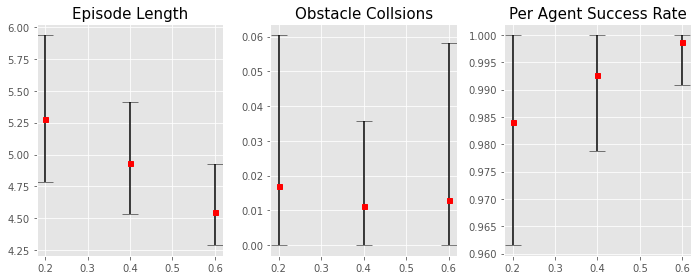

In [11]:
marker = "objdensity"
dat_filter_terms = ["primal6"]
fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 500, discard = 0.1, mode = 'mean')

In [12]:
save_as = "plots/4/ppo_4_1_5x5.png" 
fig.savefig(make_exist(save_as))

# 7x7

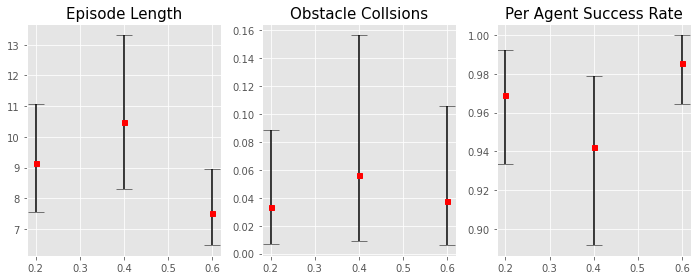

In [14]:
marker = "objdensity"
dat_filter_terms = ["primal7"]
fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 500, discard = 0.1, mode = 'mean')

In [15]:
save_as = "plots/4/ppo_4_1_7x7.png" 
fig.savefig(make_exist(save_as))

# 4.2 : Number of agents

In [17]:
source = "/home/james/Desktop/Gridworld/CENTRAL_TENSORBOARD/4_2"
all_data = get_event_data(source, False)

In [18]:
fields_titles = {
    "total_steps": "Episode Length",
    "total_agent_collisions": "Agent Collisions",
    #"total_obstacle_collisions": "Obstacle Collsions",
    "agent_dones": "Per Agent Success Rate",
    "all_agents_on_goal": "Task Success Rate"
}


# MAAC 5x5

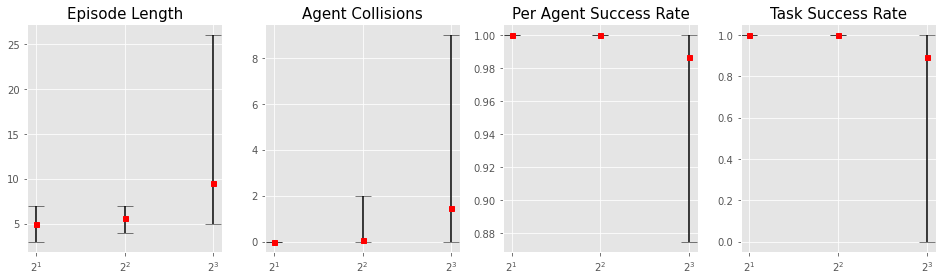

In [42]:
marker = "nagents"
dat_filter_terms = ["maac","primal6"]
fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='mean', use_log2 = True)

In [43]:
save_as = "plots/4/maac_4_2_5x5_inc_agents.png" 
fig.savefig(make_exist(save_as))

# MAAC 7x7

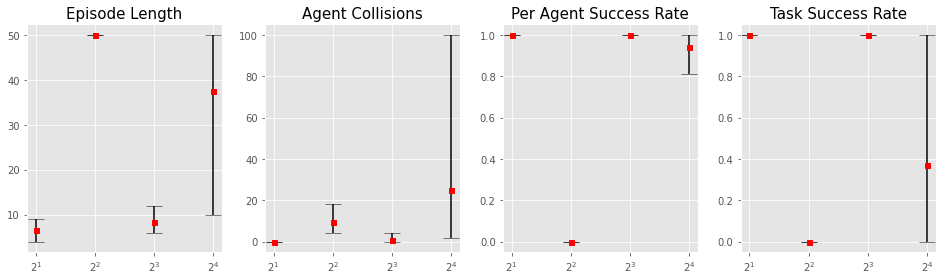

In [44]:
marker = "nagents"
dat_filter_terms = ["maac","primal7"]
fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='mean', use_log2 = True)

In [ ]:
save_as = "plots/4/maac_4_2_7x7_inc_agents.png" 
fig.savefig(make_exist(save_as))

# PPO 5x5

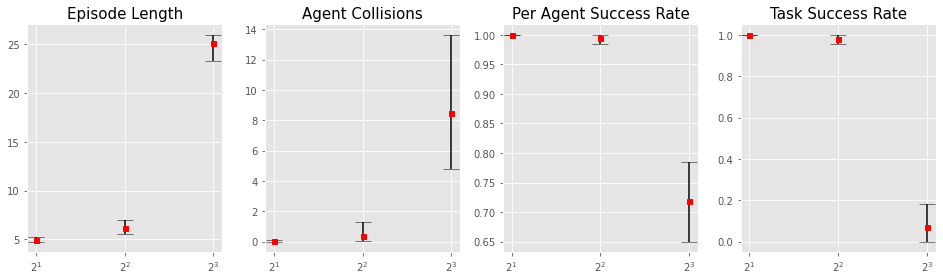

In [45]:
marker = "nagents"
dat_filter_terms = ["ppo41","primal6"]
fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='mean', use_log2 = True)

dfgdfg


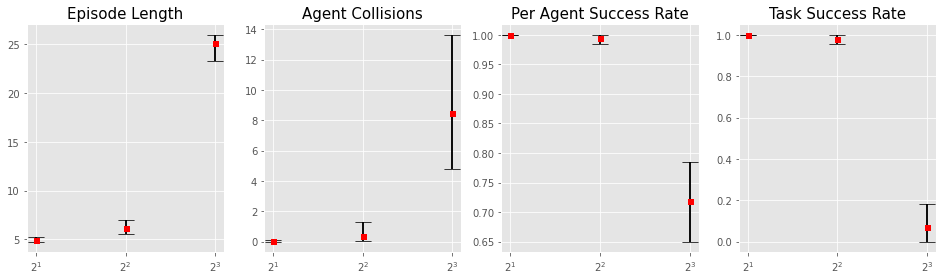

In [83]:
marker = "nagents"
dat_filter_terms1 = ["ppo41","primal6"]
fig, all_ax = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='mean', use_log2 = True)
dat_filter_terms1 = ["maac","primal6"]
print("dfgdfg")
fig, all_ax = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='mean', use_log2 = True,custom_ax_fig = (fig,all_ax))

In [ ]:
# data_filter_term = ["primal6"]
# filtered_data = filter(all_data, data_filter_term)

# #make plt_xvals
# marker = "nagents"
# plt_xvals = {}
# for k in filtered_data.keys():
#     split_terms = k.split("_")
#     ind = split_terms.index(marker)
#     x_val = float(split_terms[ind+1])
#     plt_xvals[k] = x_val

    

In [ ]:
# n_subplots = len(fields_titles)
# fig, all_ax = plt.subplots(1,n_subplots, figsize=(n_subplots*3.3,4))

# all_ax_return = scatter_errorbars(all_ax, filtered_data, plt_xvals, fields_titles, last_data = -500)

# fig.tight_layout()

In [19]:
# marker = "nagents"
# dat_filter_terms = ["maac","primal6"]
# fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='median')

In [20]:
# marker = "nagents"
# dat_filter_terms = ["maac","primal6"]
# fig = temp_plt(all_data, marker, dat_filter_terms, fields_titles, last_data = 200, discard = 0.1, mode='mean')

TypeError: LogScale got an unexpected keyword argument 'base'

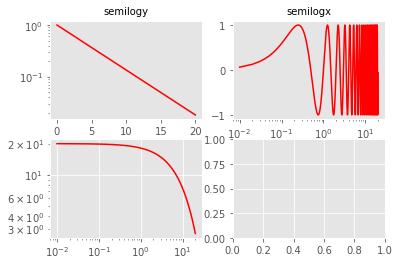

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Data for plotting
t = np.arange(0.01, 20.0, 0.01)

# Create figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# log y axis
ax1.semilogy(t, np.exp(-t / 5.0))
ax1.set(title='semilogy')
ax1.grid()

# log x axis
ax2.semilogx(t, np.sin(2 * np.pi * t))
ax2.set(title='semilogx')
ax2.grid()

# log x and y axis
ax3.loglog(t, 20 * np.exp(-t / 10.0))
ax3.set_xscale('log', base=2)
ax3.set(title='loglog base 2 on x')
ax3.grid()

# With errorbars: clip non-positive values
# Use new data for plotting
x = 10.0**np.linspace(0.0, 2.0, 20)
y = x**2.0

ax4.set_xscale("log", nonpositive='clip')
ax4.set_yscale("log", nonpositive='clip')
ax4.set(title='Errorbars go negative')
ax4.errorbar(x, y, xerr=0.1 * x, yerr=5.0 + 0.75 * y)
# ylim must be set after errorbar to allow errorbar to autoscale limits
ax4.set_ylim(bottom=0.1)

fig.tight_layout()
plt.show()